In [1]:
import numpy as np

import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import cm

import scipy.stats as ss
from scipy.io import mmread

import seaborn as sns
import pandas as pd

# ref: https://matplotlib.org/gallery/api/font_family_rc_sgskip.html
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams["mathtext.fontset"] = 'dejavusans'

In [35]:
# brew colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_cont = LinearSegmentedColormap.from_list("gtor", ['grey', 'orange', 'red', 'red'])
cmap_cat = plt.get_cmap('Paired')

# Figure 3

In [29]:
def fig3a_plot(axes):
    tsne_old = pd.read_csv('tsne_sct.csv', index_col=0)
    tsne_new = pd.read_csv('tsne_rdpca.csv', index_col=0)
    meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
    meta.index = tsne_old.index
    
    idx = (meta['cell.type.coarse'].isin(['DC', 'CD14 Monocyte', 'CD16 Monocyte']))
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne_old, hue=meta.loc[idx,'cell.type.coarse'], ax=axes[0], s=10,
                   palette=sns.color_palette("Set1", meta.loc[idx,'cell.type.coarse'].unique().shape[0]))
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne_new, hue=meta.loc[idx,'cell.type.coarse'], ax=axes[1], s=10, legend=False,
                   palette=sns.color_palette("Set1", meta.loc[idx,'cell.type.coarse'].unique().shape[0]))
    
    
    axes[0].set_xlim([0, 70])
    axes[0].set_ylim([-20, 40])
    
    axes[1].set_xlim([5, 45])
    axes[1].set_ylim([-40, 5])
    
    for ax in axes:
        ax.axis('off')
    """
    """
    
    handles, _ = axes[0].get_legend_handles_labels() 
    axes[0].legend(handles=handles, labels=['CD14+ Monocytes', 'CD16+ Monocytes', 'DCs'], 
                        fontsize=15, frameon=False)
    
    txts = ['PCA + SCTransform', 'RdPCA']
    for ax, txt in zip(axes, txts):
        ax.text(0.5, 1, txt, fontsize=20, fontweight='bold', ha='center', va='bottom', transform=ax.transAxes)

In [78]:
def fig3b_plot(axes):
    meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
    tsne_new = pd.read_csv('tsne_rdpca.csv', index_col=0)
    expr = pd.read_csv('exprs.csv', index_col=0)
    genes = ['FCGR3A', 'CD14', 'ETS1', 'TRBC2', 'CD3D', 'PTPRCAP', 'PRF1', 'SLC38A1']
    tsne_new.index = meta.index
    expr.columns = meta.index
    
    idx = (meta['cell.type.coarse'].isin(['DCs', 'CD14 Monocyte', 'CD16 Monocyte'])).values
    for ax, gene in zip(axes, genes):
        sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne_new, hue=np.log(1e-1+expr.loc[gene, idx]), palette=cmap_cont, 
                       legend=False, ax=ax, s=1)
        ax.set_xlim([5, 45])
        ax.set_ylim([-40, 5])
        ax.axis('off')
        ax.text(0.9, 1, '%s' % gene.replace('.','-'), ha='right', va='bottom', transform=ax.transAxes, fontstyle='italic', fontsize=14)

In [63]:
from matplotlib.patches import PathPatch

def fig3c_plot(ax):
    meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
    meta['seurat_clusters'] = pd.read_csv('seurat_clusters.csv', index_col=0)['seurat_clusters'].values
    idx1 = (meta['cell.type.coarse'].isin(['CD14 Monocyte', 'CD16 Monocyte']))
    idx2 = (meta['seurat_clusters'].isin([3,5,7,10]))
    meta_used = meta.loc[idx1 & idx2,['cell.type.coarse', 'seurat_clusters', 'nCount_RNA']]
    meta_used['seurat_clusters'].replace([3,5], 'T(-)',inplace=True)
    meta_used['seurat_clusters'].replace([7,10], 'T(+)',inplace=True)
    meta_used
    sns.boxplot(x='cell.type.coarse', y='nCount_RNA', hue='seurat_clusters', data=meta_used, ax=ax, width=0.5)

    cols = ['grey', 'orange'] * 2
    for i, (box, col) in enumerate(zip(ax.artists,cols)):
            box.set_facecolor('white')
            box.set_edgecolor(col)

            for j in range(6*i, 6*(i+1)):
                ax.lines[j].set_color(col)
    
    handles, _ = ax.get_legend_handles_labels() 
    ax.legend(handles=handles, labels=['Subcluster without T marker expression', 'Subcluster with T marker expression'], loc='lower right', 
                        fontsize=15, frameon=False, bbox_to_anchor=(1, 1))
    

    leg = ax.get_legend()
    leg.legendHandles[0].set_edgecolor('grey')
    leg.legendHandles[1].set_edgecolor('orange')
    leg.legendHandles[0].set_facecolor('none')
    leg.legendHandles[1].set_facecolor('none')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_xticklabels(['CD14+ Monocytes', 'CD16+ Monocytes'], fontsize=15, fontweight='bold')
    ax.set_ylabel('Total UMI counts', fontsize=15, fontweight='bold')
    ax.yaxis.set_tick_params(labelsize=15)
    
    fac=0.8
    # iterating through axes artists:
    for c in ax.get_children():

        # searching for PathPatches
        if isinstance(c, PathPatch):
            # getting current width of box:
            p = c.get_path()
            verts = p.vertices
            verts_sub = verts[:-1]
            xmin = np.min(verts_sub[:, 0])
            xmax = np.max(verts_sub[:, 0])
            xmid = 0.5*(xmin+xmax)
            xhalf = 0.5*(xmax - xmin)

            # setting new width of box
            xmin_new = xmid-fac*xhalf
            xmax_new = xmid+fac*xhalf
            verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
            verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new
             # setting new width of median line
            for l in ax.lines:
                if np.all(l.get_xdata() == [xmin, xmax]):
                    l.set_xdata([xmin_new, xmax_new])
    

In [112]:
def fig3d_plot(ax):
    deg = pd.read_csv('deg_tmarker.csv', index_col=0)
    ax.axis('off')
    
    def cell_func(x):
        if np.abs(x) > 1e-2:
            return '$%.2f$' % x
        elif x == 0:
            return '$0$'
        else:
            val = x / (10 ** (int(np.log10(x))-1))
            pow10 = int(np.log10(x))
            return ('$%.2f$' % val) + (r'$\times 10^{%d}$' % pow10)

    table_val = deg[['avg_log2FC', 'p_val_adj']].iloc[:15,:]
    table = ax.table(cellText=table_val.applymap(cell_func).values,
                      rowLabels=table_val.index,
                      colWidths=[1/3,1/3],
                      colLabels=['avg logFC', 'P-value'],
                      loc='center right',
                             )
    table.set_fontsize(15)
    table.scale(1, 1.5)

In [104]:
def fig3e_plot(ax):
    tsne_new = pd.read_csv('tsne_rdpca.csv', index_col=0)
    meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
    doublet = pd.read_csv('doublet.csv', index_col=0)
    tsne_new.index = meta.index
    
    idx = (meta['cell.type.coarse'].isin(['DC', 'CD14 Monocyte', 'CD16 Monocyte']))
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne_new, hue=doublet.loc[idx,'DF.classifications_0.25_0.005_499'], ax=ax, s=10,
                   palette=['grey', 'darkorange'])

    ax.set_xlim([-5, 45])
    ax.set_ylim([-40, 10])
    ax.axis('off')
    
    handles, _ = ax.get_legend_handles_labels() 
    ax.legend(handles=handles, labels=['Singlets', 'Putative\nmultiplets'], loc='upper right', 
                        fontsize=18, frameon=False)

In [103]:
def fig3f_plot(ax):
    tsne_new = pd.read_csv('tsne_rdpca.csv', index_col=0)
    meta = pd.read_csv('../data/pbmc_covid19/meta.csv', index_col=0)
    doublet = pd.read_csv('doublet.csv', index_col=0)
    tsne_new.index = meta.index
    
    idx1 = (meta['cell.type.coarse'].isin(['DC', 'CD14 Monocyte', 'CD16 Monocyte']))
    idx2 = (doublet['DF.classifications_0.25_0.005_499'] == 'Singlet')
    idx = idx1 & idx2
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=tsne_new, hue=meta.loc[idx,'cell.type.coarse'], ax=ax, s=10, 
                   palette=sns.color_palette("Set1", meta.loc[idx,'cell.type.coarse'].unique().shape[0]))
    
    ax.set_xlim([-5, 45])
    ax.set_ylim([-40, 10])
    ax.axis('off')
    
    handles, _ = ax.get_legend_handles_labels() 
    ax.legend(handles=handles, labels=['CD14+ Monocytes', 'CD16+ Monocytes', 'DCs'], loc='upper right', 
                        fontsize=18, frameon=False)

/home/hanbin973/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


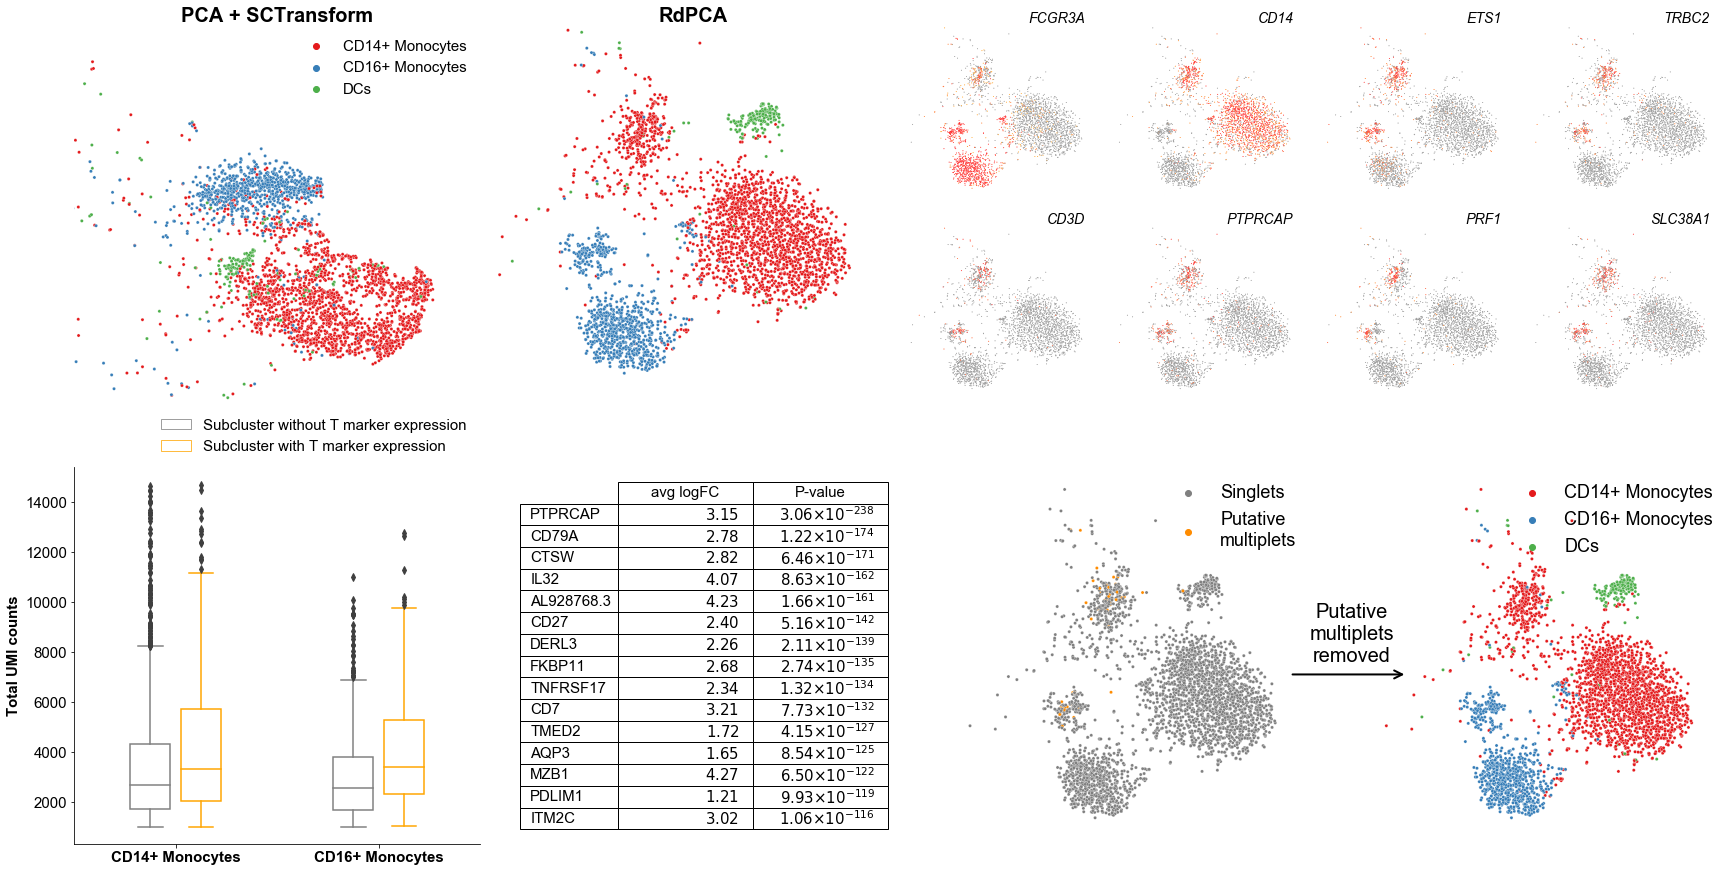

In [113]:
fig3 = plt.figure(figsize=(24, 12), constrained_layout=True) # 가로 세로
gs3 = fig3.add_gridspec(4, 8) # 행 렬

fig3a = []
fig3a.append(fig3.add_subplot(gs3[0:2,0:2])) 
fig3a.append(fig3.add_subplot(gs3[0:2,2:4]))
fig3a_plot(fig3a)


fig3b = []
for i in range(2):
    for j in range(4):
        fig3b.append(fig3.add_subplot(gs3[i:i+1,4+j:4+j+1]))
fig3b_plot(fig3b)
    

fig3c = fig3.add_subplot(gs3[2:4,0:2])
fig3c_plot(fig3c)


fig3d = fig3.add_subplot(gs3[2:4,2:4])
fig3d_plot(fig3d)


fig3e = fig3.add_subplot(gs3[2:4,4:6])
fig3e_plot(fig3e)

fig3f = fig3.add_subplot(gs3[2:4,6:8])
fig3f_plot(fig3f)

from matplotlib.patches import ConnectionPatch
fig3.text(0.78, 0.27, 'Putative\n'+'multiplets\n'+'removed', ha='center', va='center', fontsize=20)
con = ConnectionPatch(xyA=(0.95,0.45), coordsA=fig3e.transAxes,
                      xyB=(0.2,0.45), coordsB=fig3f.transAxes,
                     arrowstyle='->', color='black', mutation_scale=20, linewidth=2)
fig3.add_artist(con)

"""   
"""

plt.show()